In [1]:
!pip install kagglehub

In [2]:
import kagglehub
# Download latest version
path = kagglehub.dataset_download("yingwurenjian/chicago-divvy-bicycle-sharing-data")

print("Path to dataset files:", path)

Path to dataset files: /home/jovyan/.cache/kagglehub/datasets/yingwurenjian/chicago-divvy-bicycle-sharing-data/versions/1


In [3]:
import pandas as pd
df = pd.read_csv(path+"/data.csv", nrows=1_000_000)

In [4]:
from sklearn.model_selection import train_test_split

df, df_final_holdout = train_test_split(df, test_size=0.5, random_state=42)

In [5]:
df_final_holdout = df_final_holdout.reset_index()

In [6]:
df = df.reset_index()
x = df.drop(columns = ['tripduration'])
y = df['tripduration']

In [7]:
x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=1/3, random_state=42
)


In [8]:
x_train = x_train.reset_index()
# this the data that will be used to train the data 


In [9]:
x_train

,level_0,index,trip_id,year,month,week,day,hour,usertype,gender,...,from_station_id,from_station_name,latitude_start,longitude_start,dpcapacity_start,to_station_id,to_station_name,latitude_end,longitude_end,dpcapacity_end
0,135822,351158,1571305,2014,5,19,0,6,Subscriber,Male,...,236,Sedgwick St & Schiller St,41.907576,-87.638517,15.0,98,LaSalle St & Washington St,41.882664,-87.632530,15.0
1,493709,658250,2718802,2014,7,30,1,12,Subscriber,Female,...,49,Dearborn St & Monroe St,41.881320,-87.629521,23.0,164,Franklin St & Lake St,41.885837,-87.635500,23.0
2,456256,117949,2093127,2014,6,24,5,9,Subscriber,Female,...,118,Sedgwick St & North Ave,41.910579,-87.638618,19.0,313,Lakeview Ave & Fullerton Pkwy,41.925858,-87.638973,19.0
3,337375,690107,2642882,2014,7,29,4,13,Subscriber,Male,...,37,Dearborn St & Adams St,41.879356,-87.629791,19.0,106,State St & Pearson St,41.897448,-87.628722,27.0
4,275839,2005,2351636,2014,6,27,0,16,Subscriber,Male,...,191,Canal St & Monroe St,41.880700,-87.639470,23.0,195,Columbus Dr & Randolph St,41.884728,-87.619521,31.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
333328,259178,303271,1672549,2014,5,20,2,12,Subscriber,Male,...,33,State St & Van Buren St,41.877181,-87.627844,27.0,273,Michigan Ave & 18th St,41.857937,-87.623633,15.0
333329,365838,280691,1724661,2014,5,21,0,19,Subscriber,Female,...,56,Desplaines St & Kinzie St,41.888716,-87.644448,19.0,66,Clinton St & Lake St,41.885833,-87.641382,19.0
333330,131932,449096,1362707,2014,4,15,1,18,Subscriber,Male,...,111,Sedgwick St & Huron St,41.894666,-87.638437,19.0,91,Clinton St & Washington Blvd,41.883380,-87.641170,31.0
333331,146867,373557,1525616,2014,4,18,1,8,Subscriber,Male,...,186,Ogden Ave & Race Ave,41.891795,-87.658751,15.0,196,Cityfront Plaza & N Water St,41.889875,-87.621994,19.0


In [10]:
x_test = x_test.reset_index()

In [11]:
x_test

,level_0,index,trip_id,year,month,week,day,hour,usertype,gender,...,from_station_id,from_station_name,latitude_start,longitude_start,dpcapacity_start,to_station_id,to_station_name,latitude_end,longitude_end,dpcapacity_end
0,104241,559445,1143725,2014,1,4,3,16,Subscriber,Male,...,150,Fort Dearborn Dr & 31st St,41.838556,-87.608218,11.0,272,Indiana Ave & 31st St,41.838842,-87.621857,11.0
1,199676,144549,2042287,2014,6,24,1,6,Subscriber,Male,...,226,Racine Ave & Belmont Ave,41.939743,-87.658865,15.0,58,Marshfield Ave & Cortland St,41.916017,-87.668879,19.0
2,140199,548679,1166375,2014,2,6,4,1,Subscriber,Male,...,327,Sheffield Ave & Webster Ave,41.921687,-87.653714,19.0,13,Wilton Ave & Diversey Pkwy,41.932500,-87.652681,19.0
3,132814,922814,3617367,2014,9,38,2,8,Subscriber,Male,...,251,Clarendon Ave & Leland Ave,41.967968,-87.650001,15.0,314,Ravenswood Ave & Berteau Ave,41.957921,-87.673567,15.0
4,408697,396993,1479980,2014,4,17,1,20,Subscriber,Male,...,325,Clark St & Winnemac Ave,41.973385,-87.668365,15.0,326,Clark St & Leland Ave,41.967096,-87.667429,11.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
166662,69633,340939,1590013,2014,5,19,2,8,Subscriber,Male,...,56,Desplaines St & Kinzie St,41.888716,-87.644448,19.0,217,May St & Fulton St,41.886773,-87.656001,15.0
166663,489162,798623,2398685,2014,7,27,3,17,Subscriber,Male,...,67,Sheffield Ave & Fullerton Ave,41.925602,-87.653708,15.0,300,Broadway & Barry Ave,41.937725,-87.644095,15.0
166664,452894,876643,3705598,2014,9,39,1,17,Subscriber,Female,...,53,Wells St & Erie St,41.893832,-87.634195,19.0,289,Wells St & Concord Ln,41.912202,-87.634664,19.0
166665,439140,571705,1120540,2014,1,3,0,13,Subscriber,Male,...,283,LaSalle St & Jackson Blvd,41.878170,-87.631985,23.0,77,Clinton St & Madison St,41.881582,-87.641277,23.0


## 1.2 Feature Engineering 

To start off our feature engineering we are going to drop the columns trip_id, starttime, and stoptime from the list of predictors. We will drop starttime because the same information is captured in year, month, week, day and hour columns. We will drop stoptime variable to ensure that our model is not simply just using starttime (year/month/week/day/hour) and stoptime to calculate tripduration. We will drop trip_id because it is a unique identifier for database not a true predictor. 

In [12]:
x_train = x_train.drop(columns = ['trip_id','starttime','stoptime'])
x_test = x_test.drop(columns =['trip_id','starttime','stoptime'])

In the following we will create the following features: 
- `distance_km`: distance measured by using Manhattan distance  
- `from_station_idx`: (embedding) captures station-specific congestion, elevation, neighborhood density, and typical trip behavior 
- `to_station_idx`: (embedding) captures destination-area characteristics affectign arrival congestion and travel patterns 
- `hour_sin`,`hour_cos`: Encodes time-of-day traffic patterns. Rush hour congestion directly impacts duration 
- `is_rush_hour`: Directly models peak traffic consitions 
- `is_weekend`: Weekends trips are often recreational and longer in duration 
- `delta_lat`,`delta_lon`: Encodes direction of travel; some routes may systematically take longer due to layout 
- `temperature`/`temp_squared`: Weather affects rider speed and trip behavior 
- `capacity_diff`,`capacity_ratio`: Proxy for station size and potential congestion differences 
- `month_sin`,`month_cos`: Seasonal effects (tourism, daylight, weather trends) 
- `same_station`: Edge case trips starting and ending at same location 
- `is_cold`,`is_hot`: extreme weather behavior indicators
- `gender`: Usually a weak predictor of trip duration 
- `usertype`: Moderate effect (subscribers often shorter commute trips)
- `events`: weather 
In the following block of code we implement a function that takes in the datafram enad makes the new features from the original features. 

In [13]:
# converts start lattitude and longitude to Manhattan distance  
# a function that outputs the manhattan distance for two points 
# the following would be our spatial features 
import numpy as np 
from sklearn.preprocessing import StandardScaler, OneHotEncoder

def manhattan_distance(lat1, lon1, lat2, lon2):
    # Convert degree differences
    dlat = np.abs(lat1 - lat2)
    dlon = np.abs(lon1 - lon2)
    
    # Convert to kilometers
    lat_km = dlat * 111
    lon_km = dlon * 111 * np.cos(np.radians((lat1 + lat2) / 2))
    
    return lat_km + lon_km

# -------------------------------------------------
# TRAIN PREPROCESSING
# -------------------------------------------------
from sklearn.preprocessing import StandardScaler, OneHotEncoder





def preprocess_trip_data(
    X,
    y=None,
    fit=True,
    scaler=None,
    encoder=None,
    station_to_idx=None
):

    X = X.copy()

    # -------------------------------------------------
    # 1️⃣ Drop irrelevant columns
    # -------------------------------------------------
    drop_cols = [
        "level_0",
        "index",
        "from_station_name",
        "to_station_name"
    ]
    X = X.drop(columns=[c for c in drop_cols if c in X.columns])

    # -------------------------------------------------
    # 2️⃣ Distance & Direction
    # -------------------------------------------------
    X["distance_km"] = manhattan_distance(
        X["latitude_start"],
        X["longitude_start"],
        X["latitude_end"],
        X["longitude_end"]
    )

    X["delta_lat"] = X["latitude_end"] - X["latitude_start"]
    X["delta_lon"] = X["longitude_end"] - X["longitude_start"]

    # -------------------------------------------------
    # 3️⃣ Capacity Features
    # -------------------------------------------------
    X["capacity_diff"] = X["dpcapacity_end"] - X["dpcapacity_start"]
    X["capacity_ratio"] = X["dpcapacity_end"] / (X["dpcapacity_start"] + 1e-6)

    # -------------------------------------------------
    # 4️⃣ Cyclical Time Encoding
    # -------------------------------------------------
    X["hour_sin"] = np.sin(2 * np.pi * X["hour"] / 24)
    X["hour_cos"] = np.cos(2 * np.pi * X["hour"] / 24)

    X["month_sin"] = np.sin(2 * np.pi * X["month"] / 12)
    X["month_cos"] = np.cos(2 * np.pi * X["month"] / 12)

    X["week_sin"] = np.sin(2 * np.pi * X["week"] / 52)
    X["week_cos"] = np.cos(2 * np.pi * X["week"] / 52)

    # -------------------------------------------------
    # 5️⃣ Behavioral Indicators
    # -------------------------------------------------
    X["is_weekend"] = X["day"].isin([5, 6]).astype(int)
    X["is_rush_hour"] = X["hour"].isin([7,8,9,16,17,18,19]).astype(int)

    # -------------------------------------------------
    # 6️⃣ Weather Features
    # -------------------------------------------------
    X["temp_squared"] = X["temperature"] ** 2
    X["is_cold"] = (X["temperature"] < 5).astype(int)
    X["is_hot"] = (X["temperature"] > 30).astype(int)

    # -------------------------------------------------
    # 7️⃣ Same Station Flag
    # -------------------------------------------------
    X["same_station"] = (
        X["from_station_id"] == X["to_station_id"]
    ).astype(int)

    # -------------------------------------------------
    # 8️⃣ Log Transform Target
    # -------------------------------------------------
    if y is not None:
        y_log = np.log1p(y)
    else:
        y_log = None

    # -------------------------------------------------
    # 9️⃣ Station Embedding Mapping
    # -------------------------------------------------
    if fit:
        all_stations = pd.concat([
            X["from_station_id"],
            X["to_station_id"]
        ]).unique()

        station_to_idx = {
            station_id: idx for idx, station_id in enumerate(all_stations)
        }

    # Map stations (handle unseen safely)
    X["from_station_idx"] = X["from_station_id"].map(station_to_idx).fillna(-1).astype(int)
    X["to_station_idx"] = X["to_station_id"].map(station_to_idx).fillna(-1).astype(int)

    num_stations = len(station_to_idx)

    # -------------------------------------------------
    # 🔟 One-Hot Encode Small Categoricals
    # -------------------------------------------------
    categorical_cols = ["usertype", "gender", "events"]

    if fit:
        encoder = OneHotEncoder(handle_unknown="ignore", sparse=False)
        encoded_array = encoder.fit_transform(X[categorical_cols])
    else:
        encoded_array = encoder.transform(X[categorical_cols])

    encoded_df = pd.DataFrame(
        encoded_array,
        columns=encoder.get_feature_names_out(categorical_cols),
        index=X.index
    )

    X = X.drop(columns=categorical_cols)
    X = pd.concat([X, encoded_df], axis=1)

    # -------------------------------------------------
    # 1️⃣1️⃣ Drop redundant raw features
    # -------------------------------------------------
    redundant_cols = [
        "latitude_start",
        "longitude_start",
        "latitude_end",
        "longitude_end",
        "from_station_id",
        "to_station_id",
        "hour",
        "month",
        "week",
        "year"
    ]

    X = X.drop(columns=[c for c in redundant_cols if c in X.columns])

    # -------------------------------------------------
    # 1️⃣2️⃣ Scale numeric features
    # -------------------------------------------------
    numeric_cols = X.select_dtypes(include=["float64", "int64"]).columns.tolist()

    exclude_cols = [
        "from_station_idx",
        "to_station_idx",
        "is_weekend",
        "is_rush_hour",
        "is_cold",
        "is_hot",
        "same_station"
    ]

    numeric_cols = [c for c in numeric_cols if c not in exclude_cols]

    if fit:
        scaler = StandardScaler()
        X[numeric_cols] = scaler.fit_transform(X[numeric_cols])
    else:
        X[numeric_cols] = scaler.transform(X[numeric_cols])

    if fit:
        return X, y_log, scaler, encoder, station_to_idx, num_stations
    else:
        return X, y_log




In [14]:
# Passing training data through preprocessing 
x_train_processed, y_train_log, scaler, encoder, station_map, num_stations = \
    preprocess_trip_data(x_train, y_train, fit=True)


# Passing test data through preprocessing 
x_test_processed, y_test_log = \
    preprocess_trip_data(
        x_test,
        y_test,
        fit=False,
        scaler=scaler,
        encoder=encoder,
        station_to_idx=station_map
    )



/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


## 1.3 Fitting Linear Model

In [15]:
from sklearn.linear_model import LinearRegression

x_Linear = x_train_processed.drop(
    columns=["from_station_idx", "to_station_idx"],
    errors="ignore"
)

model_Linear = LinearRegression()
model_Linear.fit(x_Linear, y_train_log)


LinearRegression()

In [16]:
print("Base Mode Linear Regression R^2:", model_Linear.score(x_Linear, y_train_log))

Base Mode Linear Regression R^2: 0.6416020447213163


In [17]:
from sklearn.metrics import mean_squared_error
# the prediction of tripduration according to the fitted linear model
x_Linear_test = x_test_processed.drop(
    columns=["from_station_idx", "to_station_idx"],
    errors="ignore"
)


y_pred = model_Linear.predict(x_Linear_test)

mse = mean_squared_error(y_test_log, y_pred)
print("Base Linear Regression test MSE:", mse)

rmse = mean_squared_error(y_test_log, y_pred, squared = False)
print("Base Linear Regression test RMSE:", rmse)

Base Linear Regression test MSE: 0.11025779308737199
Base Linear Regression test RMSE: 0.3320508893036909


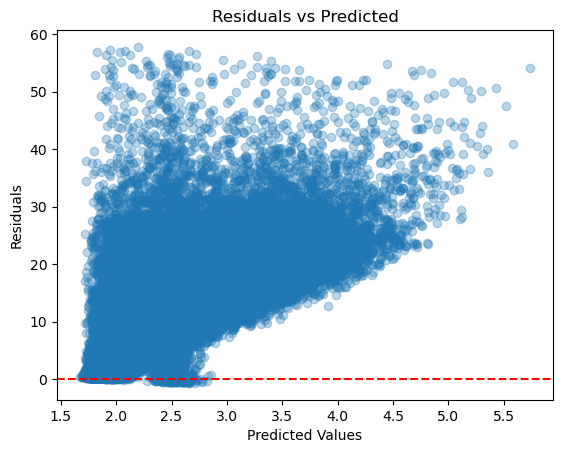

In [18]:
residuals = y_test - y_pred

import matplotlib.pyplot as plt

plt.scatter(y_pred, residuals, alpha=0.3)
plt.axhline(y=0, color='red', linestyle='--')
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.title("Residuals vs Predicted")
plt.show()


Residuals are highly dispersed and not about 0. 

Implementation of ridge regression with cross validation 
Here Ridge regression is just the implementation of linear regression with the L2-Regularization term (i.e. loss function is as follows):
$$Loss(\beta_1,...,\beta_p,\alpha) = \sum_{i=1}^{n}(y_i-\hat{y_i})^2 + \alpha\sum_{j=1}^{p}\beta_{j}^{2}$$
Here the first term measures the error, the second term penalizes the square of the coefficient values and $\alpha$ determines how strongly coefficients are constrained. In the following implementation we use cross validation to tune the hyper-parameter $\alpha$.

In [19]:
from sklearn.linear_model import RidgeCV
alphas = np.logspace(-3, 3, 50)

ridge_cv = RidgeCV(
    alphas=alphas,
    cv=5,                # 5-fold cross-validation
    scoring="neg_mean_squared_error"
)

ridge_cv.fit(x_Linear, y_train_log)

print("Best alpha selected:", ridge_cv.alpha_)


print("R^2 value is:", ridge_cv.score(x_Linear, y_train_log))

Best alpha selected: 3.5564803062231287
R^2 value is: 0.6416080013676901


In [20]:
y_predRidge = ridge_cv.predict(x_Linear_test)
mse_Ridge = mean_squared_error(y_test_log, y_predRidge)
print("Ridge Regression test MSE:", mse_Ridge)

rmse_Ridge = mean_squared_error(y_test_log, y_predRidge, squared = False)
print("Ridge Regression test RMSE:", rmse_Ridge)

Ridge Regression test MSE: 0.11025624279200197
Ridge Regression test RMSE: 0.33204855487112417


Implementation of Lasso Regression with cross validation. Here Lasso Regression is just the implementation of linear regression with the L1-Regularization.
$$Loss(\beta_1,...,\beta_n, \alpha) =\sum_{i=1}^{n}(y_{i}-\hat{y_{i}})^2 +\alpha \sum_{j=1}^{p}|\beta_{j}|$$
Here the first term measures the prediction error, the second term penalizes absolute coefficient values and $\alpha$ determines how strongly coefficients are constrained. In the following implementation we use cross validation to tune the hyper-parameter $\alpha$.

In [21]:
from sklearn.linear_model import LassoCV

lasso_cv = LassoCV(
    alphas=np.logspace(-4, 1, 30),
    cv=5,
    max_iter=10000,
    random_state=42
)

lasso_cv.fit(x_Linear, y_train_log)

print("Best alpha selected:", lasso_cv.alpha_)
print("R^2 value is:", lasso_cv.score(x_Linear, y_train_log))

Best alpha selected: 0.0001
R^2 value is: 0.6415948031789107


In [22]:
y_predLasso = lasso_cv.predict(x_Linear_test)
mse_Lasso = mean_squared_error(y_test_log, y_predLasso)
print("Lasso Regression test MSE:", mse_Lasso)

rmse_Lasso = mean_squared_error(y_test_log, y_predLasso, squared = False)
print("Lasso Regression test RMSE:", rmse_Lasso)

Lasso Regression test MSE: 0.11026017322892986
Lasso Regression test RMSE: 0.3320544732855287


## 2.1 Archtecture Design 

In [23]:
# ===============================
# 2.1 Neural Network Architecture
# ===============================

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Convert processed pandas data to tensors
X_train_tensor = torch.tensor(x_train_processed.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_log.values, dtype=torch.float32).view(-1,1)

X_val_tensor = torch.tensor(x_test_processed.values, dtype=torch.float32)
y_val_tensor = torch.tensor(y_test_log.values, dtype=torch.float32).view(-1,1)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)

train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=256)



### Define the model

Here we initialize the dimensions of our neural network. We choose our network to have the structure:
- input layer -> 128 neurons (hidden layer 1) -> 64 neurons (hidden layer 2) -> output neuron 
- choose dropout of 0.3 
    - This means that for each training pattern passed through the network 30% of neurons will be deactivated to prevent coadaptation (overfitting)

In [24]:
class TabularNN(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        
        self.model = nn.Sequential(
            nn.Linear(input_dim, 128),   # Hidden layer 1
            nn.ReLU(),
            nn.Dropout(0.3),
            
            nn.Linear(128, 64),          # Hidden layer 2
            nn.ReLU(),
            nn.Dropout(0.3),
            
            nn.Linear(64, 1)             # Output layer (regression)
        )

    def forward(self, x):
        return self.model(x)


### Initialize Model and Optimizer 

Here we do three things, namely we choose our optimizer (Adam), we initialize our learning rate, we initialize our weight decay
- We choose our optimizer to be Adam (as it is industry standard) 
- We initialize our learning rate to 1e-3 as this was the recommended setting 
- We initialize our weight decay as 1e-4 as this was the recommended setting 

In [25]:
input_dim = X_train_tensor.shape[1]

model = TabularNN(input_dim).to(device)

criterion = nn.MSELoss()

optimizer = torch.optim.Adam(
    model.parameters(),
    lr=1e-3,          # Initial learning rate
    weight_decay=1e-4 # L2 regularization
)


### Training Loop 

In [26]:
def train_nn(model, train_loader, val_loader, epochs=20):
    for epoch in range(epochs):
        model.train()
        train_loss = 0
        
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            
            preds = model(xb)
            loss = criterion(preds, yb)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
        
        model.eval()
        val_loss = 0
        
        with torch.no_grad():
            for xb, yb in val_loader:
                xb, yb = xb.to(device), yb.to(device)
                preds = model(xb)
                val_loss += criterion(preds, yb).item()
        
        print(f"Epoch {epoch+1}: "
              f"Train Loss={train_loss/len(train_loader):.4f}, "
              f"Val Loss={val_loss/len(val_loader):.4f}")


### Train the model 

In [27]:
train_nn(model, train_loader, val_loader, epochs=20)

Epoch 1: Train Loss=0.5568, Val Loss=0.1287
Epoch 2: Train Loss=0.2021, Val Loss=0.1111
Epoch 3: Train Loss=0.1505, Val Loss=0.0992
Epoch 4: Train Loss=0.1230, Val Loss=0.0871
Epoch 5: Train Loss=0.1018, Val Loss=0.0856
Epoch 6: Train Loss=0.0923, Val Loss=0.0882
Epoch 7: Train Loss=0.0895, Val Loss=0.0936
Epoch 8: Train Loss=0.0881, Val Loss=0.0878
Epoch 9: Train Loss=0.0879, Val Loss=0.0942
Epoch 10: Train Loss=0.0876, Val Loss=0.0954
Epoch 11: Train Loss=0.0874, Val Loss=0.1017
Epoch 12: Train Loss=0.0878, Val Loss=0.0979
Epoch 13: Train Loss=0.0874, Val Loss=0.0990
Epoch 14: Train Loss=0.0873, Val Loss=0.1046
Epoch 15: Train Loss=0.0879, Val Loss=0.0914
Epoch 16: Train Loss=0.0876, Val Loss=0.0962
Epoch 17: Train Loss=0.0877, Val Loss=0.1008
Epoch 18: Train Loss=0.0875, Val Loss=0.0897
Epoch 19: Train Loss=0.0875, Val Loss=0.0929
Epoch 20: Train Loss=0.0873, Val Loss=0.0918


### The above gives the following 

- Architecture: 128 -> 64 -> 1 
- Dropout: 0.3 
- Weight Decay: 1e-4
- Learning Rate: 1e-3 
- Batch Size: 256 
- Clean separation between training and validation 

## 2.2 Hyperparameter Training

We will:
- Run 30 trials random search 
- Tune:
    - Hidden layer size
    - Dropout 
    - Learning rate 
    - Weight Decay
- Use validation set only 
- Select the best model (save it -- weights, biases, hyperparameter settings)
- Do NOT touch final holdout 

In [30]:
# ==================================
# 2.2 Hyperparameter Tuning
# ==================================

import random
import copy

def train_and_validate(hidden_dim, dropout, lr, weight_decay, epochs=20):
    
    model = TabularNN(input_dim).to(device)
    
    # Update architecture dynamically
    model.model = nn.Sequential(
        nn.Linear(input_dim, hidden_dim),
        nn.ReLU(),
        nn.Dropout(dropout),
        
        nn.Linear(hidden_dim, hidden_dim // 2),
        nn.ReLU(),
        nn.Dropout(dropout),
        
        nn.Linear(hidden_dim // 2, 1)
    )
    
    # NOW move everything to the target device
    model = model.to(device)
    
    optimizer = torch.optim.Adam(
        model.parameters(),
        lr=lr,
        weight_decay=weight_decay
    )
    
    criterion = nn.MSELoss()
    
    for epoch in range(epochs):
        model.train()
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            
            preds = model(xb)
            loss = criterion(preds, yb)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
    
    # Validation loss
    model.eval()
    val_loss = 0
    
    with torch.no_grad():
        for xb, yb in val_loader:
            xb, yb = xb.to(device), yb.to(device)
            preds = model(xb)
            val_loss += criterion(preds, yb).item()
    
    val_loss /= len(val_loader)
    
    return val_loss, model


In [31]:
num_trials = 30  # 20–50 allowed
best_val_loss = float("inf")
best_model = None
best_config = None

for trial in range(num_trials):
    
    hidden_dim = random.choice([64, 128, 256])
    dropout = random.choice([0.2, 0.3, 0.4])
    lr = random.choice([1e-3, 5e-4, 1e-4])
    weight_decay = random.choice([1e-3, 1e-4, 1e-5])
    
    val_loss, model = train_and_validate(
        hidden_dim,
        dropout,
        lr,
        weight_decay,
        epochs=20
    )
    
    print(f"Trial {trial+1}/{num_trials} | "
          f"Val Loss: {val_loss:.4f} | "
          f"Hidden: {hidden_dim} | "
          f"Dropout: {dropout} | "
          f"LR: {lr} | "
          f"WD: {weight_decay}")
    
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model = copy.deepcopy(model)
        best_config = (hidden_dim, dropout, lr, weight_decay)

print("\nBest Validation Loss:", best_val_loss)
print("Best Hyperparameters:", best_config)


Trial 1/30 | Val Loss: 0.0827 | Hidden: 64 | Dropout: 0.2 | LR: 0.0005 | WD: 0.0001
Trial 2/30 | Val Loss: 0.0801 | Hidden: 64 | Dropout: 0.3 | LR: 0.0005 | WD: 1e-05
Trial 3/30 | Val Loss: 0.0867 | Hidden: 128 | Dropout: 0.2 | LR: 0.001 | WD: 1e-05
Trial 4/30 | Val Loss: 0.1093 | Hidden: 256 | Dropout: 0.4 | LR: 0.001 | WD: 0.001
Trial 5/30 | Val Loss: 0.0866 | Hidden: 128 | Dropout: 0.3 | LR: 0.0005 | WD: 0.0001
Trial 6/30 | Val Loss: 0.0954 | Hidden: 128 | Dropout: 0.3 | LR: 0.001 | WD: 0.0001
Trial 7/30 | Val Loss: 0.1016 | Hidden: 256 | Dropout: 0.3 | LR: 0.001 | WD: 0.0001
Trial 8/30 | Val Loss: 0.0872 | Hidden: 64 | Dropout: 0.4 | LR: 0.0001 | WD: 0.0001
Trial 9/30 | Val Loss: 0.0812 | Hidden: 256 | Dropout: 0.2 | LR: 0.0001 | WD: 0.0001
Trial 10/30 | Val Loss: 0.0818 | Hidden: 64 | Dropout: 0.3 | LR: 0.0001 | WD: 1e-05
Trial 11/30 | Val Loss: 0.0796 | Hidden: 128 | Dropout: 0.2 | LR: 0.0001 | WD: 0.0001
Trial 12/30 | Val Loss: 0.0901 | Hidden: 128 | Dropout: 0.3 | LR: 0.001 | W

Below we save the best model 

In [ ]:
# ==================================
# Save Full Model Checkpoint
# ==================================

import torch
import json
import numpy as np
import random

checkpoint_path = "best_nn_checkpoint.pth"

# Save everything needed for full reproducibility
checkpoint = {
    "model_state_dict": best_model.state_dict(),
    "optimizer_state_dict": optimizer.state_dict(),
    "input_dim": input_dim,
    "hidden_dim": best_config[0],
    "dropout": best_config[1],
    "learning_rate": best_config[2],
    "weight_decay": best_config[3],
    "validation_loss": best_val_loss,
    "random_seed": 42  # Replace with your actual seed if different
}

torch.save(checkpoint, checkpoint_path)

print("Full checkpoint saved to:", checkpoint_path)


## 2.3 Final Holdout Evaluation 

We now:
- Use the best tuned model 
- Evaluate it once 
- On the untouched 50% holdout set 
- Compute the final RMSE
- Do not tune anything further 

In [34]:
# ==================================
# Load Saved Model
# ==================================

checkpoint = torch.load("best_nn_checkpoint.pth")

# Rebuild model architecture
loaded_model = TabularNN(checkpoint["input_dim"]).to(device)

loaded_model.model = nn.Sequential(
    nn.Linear(checkpoint["input_dim"], checkpoint["hidden_dim"]),
    nn.ReLU(),
    nn.Dropout(checkpoint["dropout"]),
    
    nn.Linear(checkpoint["hidden_dim"], checkpoint["hidden_dim"] // 2),
    nn.ReLU(),
    nn.Dropout(checkpoint["dropout"]),
    
    nn.Linear(checkpoint["hidden_dim"] // 2, 1)
)

loaded_model = loaded_model.to(device)
loaded_model.load_state_dict(checkpoint["model_state_dict"])
loaded_model.eval()

print("Model loaded successfully.")
print("Validation Loss:", checkpoint["validation_loss"])


Model loaded successfully.
Validation Loss: 0.07821271251429993


In [35]:
# ==================================
# 2.3 Final Holdout Evaluation
# ==================================

# Preprocess holdout set using SAME pipeline
X_holdout_processed, y_holdout_log = preprocess_trip_data(
    df_final_holdout.drop(columns=['tripduration','trip_id','starttime','stoptime']),
    df_final_holdout['tripduration'],
    fit=False,
    scaler=scaler,
    encoder=encoder,
    station_to_idx=station_map
)

# Convert to tensors
X_holdout_tensor = torch.tensor(
    X_holdout_processed.values, dtype=torch.float32
).to(device)

y_holdout_tensor = torch.tensor(
    y_holdout_log.values, dtype=torch.float32
).view(-1,1).to(device)

# Set model to evaluation mode
best_model.eval()

# Compute predictions
with torch.no_grad():
    predictions = loaded_model(X_holdout_tensor)
    mse = nn.MSELoss()(predictions, y_holdout_tensor).item()


rmse = mse ** 0.5

print("=================================")
print("Final Holdout Evaluation Results")
print("=================================")
print(f"Holdout MSE  : {mse:.4f}")
print(f"Holdout RMSE : {rmse:.4f}")


Final Holdout Evaluation Results
Holdout MSE  : 0.0786
Holdout RMSE : 0.2803


## 3.1 Feature Importance

We now:

- Apply permutation importance to the trained neural network
- Measure importance as the increase in RMSE after permuting each feature
- Use the untouched evaluation set (no retraining)
- Group or interpret correlated features carefully if necessary
- Identify and report the Top 10 most important features
- Do not tune the model further based on these results

In [36]:
# ==================================
# 3.1 Feature Importance
# ==================================

import numpy as np
import pandas as pd
import torch
import torch.nn as nn

def _rmse_log(model: torch.nn.Module, X_df: pd.DataFrame, y_log, device, batch_size: int = 8192) -> float:
    model.eval()
    X = X_df.values.astype(np.float32)

    y_arr = np.asarray(y_log)
    if y_arr.ndim == 1:
        y_arr = y_arr.reshape(-1, 1)
    y_arr = y_arr.astype(np.float32)

    mse_sum = 0.0
    n = X.shape[0]
    criterion = nn.MSELoss(reduction="sum")

    with torch.no_grad():
        for start in range(0, n, batch_size):
            end = min(start + batch_size, n)
            xb = torch.from_numpy(X[start:end]).to(device)
            yb = torch.from_numpy(y_arr[start:end]).to(device)
            preds = model(xb)
            mse_sum += criterion(preds, yb).item()

    return float(np.sqrt(mse_sum / n))


def permutation_importance_nn(
    model: torch.nn.Module,
    X_df: pd.DataFrame,
    y_log,
    device,
    n_repeats: int = 5,
    seed: int = 42,
    batch_size: int = 8192
) -> tuple[pd.DataFrame, float]:

    rng = np.random.default_rng(seed)
    X_work = X_df.copy(deep=True)

    baseline = _rmse_log(model, X_work, y_log, device=device, batch_size=batch_size)

    feature_names = list(X_work.columns)
    importances = np.zeros((len(feature_names), n_repeats), dtype=np.float64)

    for j, feat in enumerate(feature_names):
        original = X_work[feat].to_numpy(copy=True)

        for r in range(n_repeats):
            perm_idx = rng.permutation(len(X_work))
            X_work.loc[:, feat] = original[perm_idx]
            perm_rmse = _rmse_log(model, X_work, y_log, device=device, batch_size=batch_size)
            importances[j, r] = perm_rmse - baseline

        X_work.loc[:, feat] = original

    df_imp = pd.DataFrame({
        "feature": feature_names,
        "importance_mean": importances.mean(axis=1),
        "importance_std": importances.std(axis=1, ddof=1) if n_repeats > 1 else 0.0,
    }).sort_values("importance_mean", ascending=False).reset_index(drop=True)

    return df_imp, baseline

In [37]:
# ==================================
# Run on Validation/Test
# ==================================

perm_imp_df, baseline_rmse = permutation_importance_nn(
    model=loaded_model,
    X_df=x_test_processed,
    y_log=y_test_log,
    device=device,
    n_repeats=5,
    seed=42,
    batch_size=8192
)

print(f"Baseline RMSE (log space): {baseline_rmse:.6f}")
display(perm_imp_df.head(10))

Baseline RMSE (log space): 0.279462


,feature,importance_mean,importance_std
0,distance_km,0.439000,0.000867
1,same_station,0.040794,0.000170
2,gender_Male,0.013095,0.000134
3,delta_lat,0.008016,0.000108
4,delta_lon,0.007600,0.000119
5,is_hot,0.003391,0.000118
6,temperature,0.002845,0.000056
7,dpcapacity_start,0.002626,0.000081
8,hour_sin,0.002387,0.000074
9,hour_cos,0.002211,0.000056


In [38]:
# ==================================
# Top 10 features table
# ==================================

top10 = perm_imp_df.head(10).copy()
top10["importance_mean"] = top10["importance_mean"].astype(float)
top10["importance_std"] = top10["importance_std"].astype(float)

print("Top 10 features by permutation importance (ΔRMSE in log space):")
display(top10)

Top 10 features by permutation importance (ΔRMSE in log space):


,feature,importance_mean,importance_std
0,distance_km,0.439000,0.000867
1,same_station,0.040794,0.000170
2,gender_Male,0.013095,0.000134
3,delta_lat,0.008016,0.000108
4,delta_lon,0.007600,0.000119
5,is_hot,0.003391,0.000118
6,temperature,0.002845,0.000056
7,dpcapacity_start,0.002626,0.000081
8,hour_sin,0.002387,0.000074
9,hour_cos,0.002211,0.000056


# 3.2 Paired Seed Evaluation (Frozen Tuned NN vs Baselines)

This section evaluates the tuned neural network against baseline models
across multiple random seeds.

- Model hyperparameters are frozen.
- Preprocessing and data split remain fixed.
- Only model initialization randomness varies.

In [42]:
# ==================================
# 3.2 Paired Seed Evaluation (Frozen Tuned NN)
# ==================================

import numpy as np
import pandas as pd
import random
import torch
import torch.nn as nn

from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

from scipy.stats import shapiro, ttest_rel, wilcoxon


# -------------------------------
# 0) Helpers
# -------------------------------
def set_all_seeds(seed: int):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    # optional determinism (NRP/GPU kernels can still be non-deterministic)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


def rmse(y_true, y_pred):
    return float(np.sqrt(mean_squared_error(y_true, y_pred)))


def compute_metrics(y_true, y_pred):
    return {
        "RMSE": rmse(y_true, y_pred),
        "MAE": float(mean_absolute_error(y_true, y_pred)),
        "R2": float(r2_score(y_true, y_pred)),
    }


def get_linear_features(df_processed: pd.DataFrame):
    # Your baseline cells drop station idx columns; keep consistent.
    return df_processed.drop(columns=["from_station_idx", "to_station_idx"], errors="ignore")


@torch.no_grad()
def predict_nn(model: torch.nn.Module, X_tensor: torch.Tensor, batch_size=1024, device="cpu"):
    model.eval()
    preds = []
    n = X_tensor.shape[0]
    for i in range(0, n, batch_size):
        xb = X_tensor[i:i+batch_size].to(device)
        yhat = model(xb).detach().cpu().numpy().reshape(-1)
        preds.append(yhat)
    return np.concatenate(preds, axis=0)


def build_frozen_tuned_nn(input_dim: int, best_config: dict, device):
    """
    Rebuild your tuned architecture exactly as in train_and_validate():
      Linear(input_dim -> hidden_dim)
      Linear(hidden_dim -> hidden_dim//2)
      Linear(hidden_dim//2 -> 1)
    """
    hidden_dim = int(best_config["hidden_dim"])
    dropout = float(best_config["dropout"])

    m = TabularNN(input_dim).to(device)
    m.model = nn.Sequential(
        nn.Linear(input_dim, hidden_dim),
        nn.ReLU(),
        nn.Dropout(dropout),

        nn.Linear(hidden_dim, hidden_dim // 2),
        nn.ReLU(),
        nn.Dropout(dropout),

        nn.Linear(hidden_dim // 2, 1)
    ).to(device)
    return m


def train_nn_fixed(model, X_train_tensor, y_train_tensor, best_config, device, epochs=20):
    lr = float(best_config["learning_rate"])
    weight_decay = float(best_config["weight_decay"])

    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    criterion = nn.MSELoss()

    model.train()
    for epoch in range(epochs):
        # full-batch-ish loop (simple + consistent)
        perm = torch.randperm(X_train_tensor.size(0))
        Xb = X_train_tensor[perm].to(device)
        yb = y_train_tensor[perm].to(device)

        optimizer.zero_grad()
        yhat = model(Xb)
        loss = criterion(yhat, yb)
        loss.backward()
        optimizer.step()

    return model


# -------------------------------
# 1) Freeze configs (load tuned hyperparameters)
# -------------------------------
# checkpoint = torch.load("best_nn_checkpoint.pth", map_location="cpu")
checkpoint = torch.load("best_nn_checkpoint.pth")
best_config = checkpoint
# best_config = checkpoint["config"]   # {hidden_dim, dropout, lr, weight_decay, ...}

print("Frozen tuned NN config:", best_config)


# -------------------------------
# 2) Ensure holdout is preprocessed with SAME pipeline
#    (This matches your existing cell 2.3 behavior.)
# -------------------------------
# If you've already run your existing holdout preprocessing cell, you can skip this.
X_holdout_processed, y_holdout_log = preprocess_trip_data(
    df_final_holdout.drop(columns=['tripduration','trip_id','starttime','stoptime']),
    df_final_holdout['tripduration'],
    fit=False,
    scaler=scaler,
    encoder=encoder,
    station_to_idx=station_map
)

# Convert to tensors (log-space target, consistent with notebook)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

X_train_tensor = torch.tensor(x_train_processed.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_log.values, dtype=torch.float32).view(-1, 1)

X_holdout_tensor = torch.tensor(X_holdout_processed.values, dtype=torch.float32)

y_holdout = y_holdout_log.values.astype(float)  # keep as numpy 1D


# -------------------------------
# 3) Seeds (10 seeds: 0..9, optionally include 42)
# -------------------------------
seeds = list(range(10))
# Uncomment if you want to include your existing run as a datapoint:
# if 42 not in seeds:
#     seeds.append(42)


# -------------------------------
# 4) Run paired evaluations per seed
# -------------------------------
rows = []

for seed in seeds:
    set_all_seeds(seed)

    # ---- Train baselines on same train set (log target) ----
    X_train_lin = get_linear_features(x_train_processed)
    X_holdout_lin = get_linear_features(X_holdout_processed)

    # Linear Regression
    lin = LinearRegression()
    lin.fit(X_train_lin, y_train_log)
    lin_pred = lin.predict(X_holdout_lin)

    lin_metrics = compute_metrics(y_holdout, lin_pred)

    # RidgeCV (deterministic CV folds by default; still retrained each loop for consistency)
    ridge = RidgeCV(alphas=np.logspace(-3, 3, 50), cv=5)
    ridge.fit(X_train_lin, y_train_log)
    ridge_pred = ridge.predict(X_holdout_lin)
    ridge_metrics = compute_metrics(y_holdout, ridge_pred)

    # LassoCV (has randomness; tie it to the current seed)
    lasso = LassoCV(alphas=np.logspace(-4, 1, 30), cv=5, max_iter=10000, random_state=seed)
    lasso.fit(X_train_lin, y_train_log)
    lasso_pred = lasso.predict(X_holdout_lin)
    lasso_metrics = compute_metrics(y_holdout, lasso_pred)

    # ---- Train frozen tuned NN (only init/training randomness varies by seed) ----
    nn_model = build_frozen_tuned_nn(input_dim=X_train_tensor.shape[1], best_config=best_config, device=device)
    nn_model = train_nn_fixed(
        nn_model,
        X_train_tensor,
        y_train_tensor,
        best_config=best_config,
        device=device,
        epochs=20  # keep consistent with typical training; adjust if you used a different final epoch count
    )

    nn_pred = predict_nn(nn_model, X_holdout_tensor, batch_size=1024, device=device).reshape(-1)
    nn_metrics = compute_metrics(y_holdout, nn_pred)

    # ---- Store seed-level results + deltas ----
    # Deltas as in your screenshot:
    # Delta RMSE = RMSE_baseline - RMSE_NN
    # Delta MAE  = MAE_baseline  - MAE_NN
    # Delta R2   = R2_baseline   - R2_NN
    for baseline_name, base_metrics in [
        ("Linear", lin_metrics),
        ("Ridge", ridge_metrics),
        ("Lasso", lasso_metrics),
    ]:
        rows.append({
            "seed": seed,
            "baseline": baseline_name,

            "RMSE_baseline": base_metrics["RMSE"],
            "MAE_baseline": base_metrics["MAE"],
            "R2_baseline": base_metrics["R2"],

            "RMSE_NN": nn_metrics["RMSE"],
            "MAE_NN": nn_metrics["MAE"],
            "R2_NN": nn_metrics["R2"],

            "Delta_RMSE": base_metrics["RMSE"] - nn_metrics["RMSE"],
            "Delta_MAE": base_metrics["MAE"] - nn_metrics["MAE"],
            "Delta_R2": base_metrics["R2"] - nn_metrics["R2"],
        })

results_df = pd.DataFrame(rows)
results_df.head()

Frozen tuned NN config: {'model_state_dict': OrderedDict([('model.0.weight', tensor([[-0.0061,  0.0423, -0.0335,  ..., -0.0138, -0.0082, -0.0009],
        [ 0.0028,  0.0060,  0.0086,  ..., -0.0022,  0.0054,  0.0333],
        [ 0.0302, -0.0089,  0.0653,  ...,  0.0474,  0.0313,  0.0027],
        ...,
        [ 0.0100,  0.0086,  0.0179,  ..., -0.0688, -0.0358, -0.0088],
        [-0.0031, -0.0041, -0.0064,  ..., -0.0018,  0.0110, -0.0031],
        [-0.1140, -0.0265, -0.0365,  ...,  0.0169, -0.0534,  0.0047]])), ('model.0.bias', tensor([-3.0710e-02, -1.8541e-02,  4.5962e-02, -3.3670e-03, -2.8136e-02,
         1.3280e-01,  8.4095e-05,  1.7904e-02, -3.7424e-02,  3.2170e-01,
        -3.8836e-03, -4.5786e-38, -1.6794e-02, -2.8443e-02, -1.8105e-02,
        -1.9631e-01, -1.3054e-02, -1.4384e-02, -2.5777e-01,  2.6767e-01,
         3.8361e-01,  5.2351e-01,  2.5841e-01,  1.7444e-01, -1.9364e-02,
         1.5681e-01, -1.2345e-02,  3.0505e-01,  2.9072e-02,  2.0639e-01,
        -3.9421e-01, -9.6157e-02

,seed,baseline,RMSE_baseline,MAE_baseline,R2_baseline,RMSE_NN,MAE_NN,R2_NN,Delta_RMSE,Delta_MAE,Delta_R2
0,0,Linear,0.332800,0.247294,0.641416,1.209638,0.991175,-3.737352,-0.876838,-0.743880,4.378768
1,0,Ridge,0.332793,0.247257,0.641430,1.209638,0.991175,-3.737352,-0.876845,-0.743918,4.378782
2,0,Lasso,0.332798,0.247279,0.641420,1.209638,0.991175,-3.737352,-0.876840,-0.743896,4.378772
3,1,Linear,0.332800,0.247294,0.641416,1.520318,1.325618,-6.483311,-1.187518,-1.078323,7.124727
4,1,Ridge,0.332793,0.247257,0.641430,1.520318,1.325618,-6.483311,-1.187525,-1.078361,7.124742


In [ ]:
results_df

,seed,baseline,RMSE_baseline,MAE_baseline,R2_baseline,RMSE_NN,MAE_NN,R2_NN,Delta_RMSE,Delta_MAE,Delta_R2
0,0,Linear,0.332800,0.247294,0.641416,1.209638,0.991175,-3.737352,-0.876838,-0.743880,4.378768
1,0,Ridge,0.332793,0.247257,0.641430,1.209638,0.991175,-3.737352,-0.876845,-0.743918,4.378782
2,0,Lasso,0.332798,0.247279,0.641420,1.209638,0.991175,-3.737352,-0.876840,-0.743896,4.378772
3,1,Linear,0.332800,0.247294,0.641416,1.520318,1.325618,-6.483311,-1.187518,-1.078323,7.124727
4,1,Ridge,0.332793,0.247257,0.641430,1.520318,1.325618,-6.483311,-1.187525,-1.078361,7.124742
5,1,Lasso,0.332798,0.247279,0.641420,1.520318,1.325618,-6.483311,-1.187520,-1.078339,7.124732
6,2,Linear,0.332800,0.247294,0.641416,1.367621,1.155970,-5.055589,-1.034821,-0.908675,5.697005
7,2,Ridge,0.332793,0.247257,0.641430,1.367621,1.155970,-5.055589,-1.034828,-0.908713,5.697020
8,2,Lasso,0.332798,0.247279,0.641420,1.367621,1.155970,-5.055589,-1.034823,-0.908691,5.697010
9,3,Linear,0.332800,0.247294,0.641416,1.230364,1.013631,-3.901081,-0.897564,-0.766336,4.542497
